# Vision Transformer (ViT)
- 학습데이터의 양이 적으면 CNN 기반 방법보다 성능이 안좋을 수 있음(inductive bias 부족)

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
import glob
import cv2

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

In [17]:
learning_rate = 0.001
weight_decay = 0.00001
batch_size = 128
num_epochs = 10
image_size = 96
# size of the patches to be extracted from the input images
patch_size = 6
num_pathces = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
# encoder block에서의 MLP 생성을 위한 값들
transformer_units = [projection_dim*2, projection_dim]  # --> size of the transformer layers
transformer_layers = 4
# size of the dense layers of the final classifier
mlp_head_units = [1024,512] 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
train_df = pd.DataFrame()
train_df['files'] = glob.glob('./cats_and_dogs_small/train/cats/*.jpg') + glob.glob('./cats_and_dogs_small/train/dogs/*.jpg')
train_df['labels'] = [0] * len(glob.glob('./cats_and_dogs_small/train/cats/*.jpg')) + [1] * len(glob.glob('./cats_and_dogs_small/train/dogs/*.jpg'))

val_df = pd.DataFrame()
val_df['files'] = glob.glob('./cats_and_dogs_small/validation/cats/*.jpg') + glob.glob('./cats_and_dogs_small/validation/dogs/*.jpg')
val_df['labels'] = [0] * len(glob.glob('./cats_and_dogs_small/validation/cats/*.jpg')) + [1] * len(glob.glob('./cats_and_dogs_small/validation/dogs/*.jpg'))

test_df = pd.DataFrame()
test_df['files'] = glob.glob('./cats_and_dogs_small/test/cats/*.jpg') + glob.glob('./cats_and_dogs_small/test/dogs/*.jpg')
test_df['labels'] = [0] * len(glob.glob('./cats_and_dogs_small/test/cats/*.jpg')) + [1] * len(glob.glob('./cats_and_dogs_small/test/dogs/*.jpg'))

label_dict = {0: 'cat', 1: 'dog'}

train_df = train_df.sample(frac=1)
val_df = val_df.sample(frac=1)
test_df = test_df.sample(frac=1)

In [5]:
class catdogDataSet(Dataset):
    def __init__(self, files, labels, transform=None):
        super().__init__()
        self.files = files
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.files)
    def __getitem__(self, index):
        img = cv2.imread(self.files[index])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(img)
        return img, self.labels[index]

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

In [19]:
from torchvision import transforms
data_augmentation  = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=45),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=20),
    transforms.ToTensor()])
    

In [20]:
trainDS = catdogDataSet(train_df['files'].values, train_df['labels'].values, transform=data_augmentation)
valDS = catdogDataSet(val_df['files'].values, val_df['labels'].values, transform=data_augmentation)
testDS = catdogDataSet(test_df['files'].values, test_df['labels'].values, transform=data_augmentation)

(-0.5, 95.5, 95.5, -0.5)

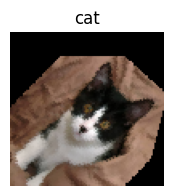

In [24]:
temp_img,temp_label = trainDS[100]
plt.figure(figsize=(2,2))
plt.imshow(temp_img.permute(1,2,0))
plt.title(label_dict[temp_label])
plt.axis('off')

In [27]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = nn.Linear(x.shape[1], units)(x)
        x = nn.GELU()(x)
        x = nn.Dropout(dropout_rate)(x)
    return x

In [70]:
class Patches(nn.Module):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def forward(self, images):
        batch_size = images.size(0)
        print(images.shape)
        patches = images.unfold(2, self.patch_size, self.patch_size)
        print(patches.shape)
        patches = patches.unfold(3, self.patch_size, self.patch_size)
        print(patches.shape)
        patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous()
        print(patches.shape)
        return patches.view(batch_size, -1, self.patch_size * self.patch_size)

In [59]:
# temp_img.unfold(2, patch_size, patch_size).shape

torch.Size([1, 3, 16, 96, 6])

In [62]:
trsf_img.shape

torch.Size([1, 768, 36])

torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 16, 96, 6])
torch.Size([1, 3, 16, 16, 6, 6])
torch.Size([1, 16, 16, 3, 6, 6])
torch.Size([1, 768, 36])


(-0.5, 35.5, 767.5, -0.5)

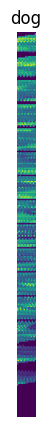

In [72]:
temp_img,temp_label = trainDS[500]
temp_img = temp_img.unsqueeze(0)
plt.figure(figsize=(5,5))
trsf_img = Patches(patch_size=patch_size)(temp_img)
print(trsf_img.shape)
plt.imshow(trsf_img.permute(1,2,0))
plt.title(label_dict[temp_label])
plt.axis('off')